In [2]:
!pip install wfdb

  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl


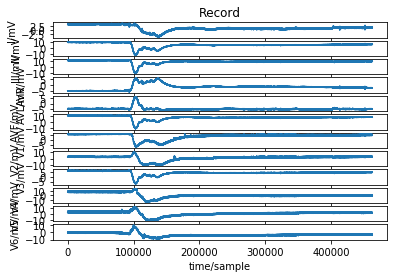

{'record_name': 'I04',
 'n_sig': 12,
 'fs': 257,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 462600,
 'base_time': None,
 'base_date': None,
 'comments': ['<age>: 59 <sex>: M <diagnoses> Acute MI',
  'patient 2',
  'bradycardia, tachycardia, PVCs, ventricular couplets, paroxysmal VT'],
 'sig_name': ['I',
  'II',
  'III',
  'AVR',
  'AVL',
  'AVF',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6'],
 'p_signal': array([[ 3.32372719, 10.29971182, 10.59942363, ...,  7.23919308,
          2.05571566, -1.18059558],
        [ 3.33045149, 10.29106628, 10.58405379, ...,  7.25456292,
          2.05283381, -1.20461095],
        [ 3.30355427, 10.29394813, 10.61383285, ...,  7.24207493,
          2.02977906, -1.23823247],
        ...,
        [ 1.40730067,  6.83669549,  9.05283381, ..., -0.62536023,
          1.11239193, -3.63592699],
        [ 1.41210375,  6.81460134,  9.0259366 , ..., -0.62247839,
          1.10854947, -3.64745437],
        [ 1.43611912,  6.80115274,  8.98847262, ...,

In [100]:
import wfdb

# Demo - Read a wfdb record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
record = wfdb.rdrecord('data/I04') 
wfdb.plot_wfdb(record=record, title='Record') 
display(record.__dict__)

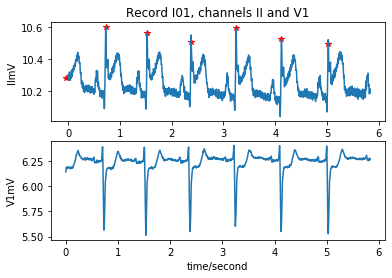

{'record_name': 'I04',
 'extension': 'atr',
 'sample': array([ -11,  187,  393,  611,  834, 1059, 1292]),
 'symbol': ['N', 'N', 'N', 'N', 'N', 'N', 'N'],
 'subtype': array([0, 0, 0, 0, 0, 0, 0]),
 'chan': array([0, 0, 0, 0, 0, 0, 0]),
 'num': array([0, 0, 0, 0, 0, 0, 0]),
 'aux_note': ['', '', '', '', '', '', ''],
 'fs': 257,
 'label_store': None,
 'description': None,
 'custom_labels': None,
 'contained_labels': None,
 'ann_len': 7}

In [103]:
# Demo 5 - Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord('data/I04', channels=[1, 6], sampto = 1500)
annotation = wfdb.rdann('data/I04', 'atr', sampto = 1500)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record I01, channels II and V1',
               time_units='seconds')

annotation.__dict__

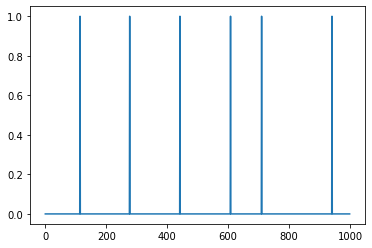

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

ticks_signal = np.zeros(channel_ii.shape)
ticks_signal[ticks] = 1.0
plt.plot(ticks_signal[:1000])

In [29]:
def parabola(a,n,r):
    assert n>2*r
    y = np.zeros(n, dtype = np.float32)
    x = np.array(range(2, 2 * r+1))
    for i in a:
        if i > r-1 and i <= n-r:
            # y[i-r-1:i+r+1] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
            y[i-r+1:i+r] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
        elif i < r:
            y[:i+r] = ((r+1)**2-(x[r-i-1:]-r-1)**2)/(r+1)**2
        elif i<n:
            y[i-r+1:] = ((r+1)**2-(x[:r-1+(n-i)]-r-1)**2)/(r+1)**2
    return y

In [30]:
def selectFromSignal(signal, seqL, ninputs, numChan=2):
    """ 
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    """
    segmentL  = seqL * ninputs; print(segmentL)
    inpOutSegment = tf.random_crop(signal, [numChan, segmentL])
    inputs = inpOutSegment[0, :]
    target = inpOutSegment[1, :]
    return inputs, target

In [51]:
record = wfdb.rdrecord('data/I01', channels=[1, 6])
annotation = wfdb.rdann('data/I01', 'atr')

signals = record.__dict__['p_signal']
# channel_ii = signals[:, 0]
# channel_v1 = signals[:, 1]

ticks = annotation.__dict__['sample']
symbols = annotation.__dict__['symbol']

channel_ii.shape, channel_v1.shape

((462600,), (462600,))

### Preprocessing

In [45]:
def removeBaseline(signal,fs):
    baseline = np.convolve(signal, np.ones(fs)/fs, mode = 'same')
    signalFinal = signal-baseline
    return signalFinal,baseline

In [153]:
record = wfdb.rdrecord('data/I01', channels=[1, 6])
annotation = wfdb.rdann('data/I01', 'atr')
signals = record.__dict__['p_signal']

N = signals.shape[0]
fs = record.__dict__['fs']
p_param = 10

import os
filenames = np.unique(list(map(lambda x : x.split('.')[0], os.listdir('data'))))
qrsAnnot = ['N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q',' ?']

all_data = np.zeros((len(filenames), signals.shape[1]+1, N), dtype=np.float32)
idx = 0

for f in filenames:
    path = 'data/{}'.format(f)
    # read annotation
    annotation = wfdb.rdann(path, 'atr')
    uniq_symbols = np.unique(annotation.__dict__['symbol'])
    
    # check if all symbols can be found in qrsAnnot list
    if not np.all([(symbol in qrsAnnot) for symbol in uniq_symbols]):
        print("! Skipping {}...".format(f))
        continue
    
    # read signals
    record = wfdb.rdrecord(path, channels=[1, 6])
    signals = record.__dict__['p_signal']
        
    # get channel II and V1
    channel_ii = signals[:, 0]
    channel_v1 = signals[:, 1]
    
    # remove baselines
    chii_data_filter, _ = removeBaseline(channel_ii, fs)
    chv1_data_filter, _ = removeBaseline(channel_v1, fs)
    
    # reshape to  -> (1, 462600)
    chii_data_filter = chii_data_filter.reshape((1, -1))
    chv1_data_filter = chv1_data_filter.reshape((1, -1))
    
    # put two signals together -> (2, 462600)
    signal = np.concatenate((chii_data_filter, chv1_data_filter), axis=0)

    # get ticks and create parabola
    ticks = annotation.__dict__['sample']
    if np.any(ticks < 0):
        print("! Negative ticks in ", f)
        ticks = ticks[1:]
#         ticks[ticks < 0] = 0.0
    
    p = parabola(ticks, N, p_param)
    
    targets = p.reshape((1, -1))
    
    # create data with signals on data[0], data[1] and ticks on data[2]
    data = np.concatenate((signal, targets), axis=0)
    
    all_data[idx] = data
    idx += 1
    print("Loaded ", f)

all_data = all_data[:idx]
print(all_data.shape)

Loaded  I01
Loaded  I02
Loaded  I03
! Negative ticks in  I04
Loaded  I04
Loaded  I05
Loaded  I06
Loaded  I07
Loaded  I08
Loaded  I09
Loaded  I10
Loaded  I11
Loaded  I12
Loaded  I13
Loaded  I14
Loaded  I15
Loaded  I16
! Negative ticks in  I17
Loaded  I17
Loaded  I18
Loaded  I19
Loaded  I20
Loaded  I21
Loaded  I22
Loaded  I23
Loaded  I24
Loaded  I25
Loaded  I26
Loaded  I27
Loaded  I28
Loaded  I29
Loaded  I30
Loaded  I31
Loaded  I32
Loaded  I33
Loaded  I34
! Negative ticks in  I35
Loaded  I35
Loaded  I36
Loaded  I37
Loaded  I38
Loaded  I39
Loaded  I40
Loaded  I41
Loaded  I42
Loaded  I43
! Negative ticks in  I44
Loaded  I44
Loaded  I45
Loaded  I46
Loaded  I47
Loaded  I48
! Skipping I49...
! Skipping I50...
Loaded  I51
Loaded  I52
Loaded  I53
Loaded  I54
Loaded  I55
Loaded  I56
! Negative ticks in  I57
Loaded  I57
Loaded  I58
Loaded  I59
Loaded  I60
Loaded  I61
Loaded  I62
Loaded  I63
Loaded  I64
Loaded  I65
Loaded  I66
Loaded  I67
! Skipping I68...
! Skipping I69...
! Skipping I70...
! Ski

In [150]:
all_data.shape

(69, 3, 462600)

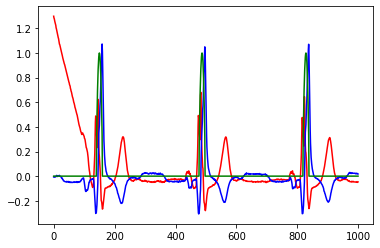

In [157]:
sig = all_data[15, :, :]
x = np.arange(sig.shape[1])

plt.plot(x[:1000], sig[0, :1000], 'r', x[:1000], sig[1, :1000], 'b', x[:1000], sig[2, :1000], 'g')

### Parameters

In [158]:
window_size = 250
p_param = 10
seqL = 20
fs = 257
ninputs = int(0.05*fs) 
batchSize = 8
testDataSize = 62600
val_perc = 0.15

(462600,)


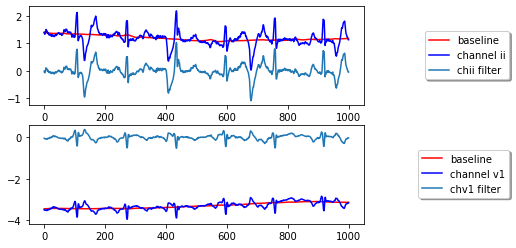

In [48]:
print(channel_ii.shape)

chii_data_filter,baseline_chii = removeBaseline(channel_ii,fs)
chv1_data_filter,baseline_chv1 = removeBaseline(channel_v1,fs)
x = range(1000)

plt.figure(1)
plt.subplot(211)
plt.plot(x,baseline_chii[1000:2000], 'r',x,channel_ii[1000:2000],'b',x,chii_data_filter[1000:2000])
plt.legend(('baseline', 'channel ii', 'chii filter'),
           loc='upper right', bbox_to_anchor=(1.45, 0.8),shadow=True, ncol=1)

plt.subplot(212)
plt.plot(x,baseline_chv1[1000:2000], 'r',x,channel_v1[1000:2000],'b',x,chv1_data_filter[1000:2000])

plt.legend(('baseline', 'channel v1', 'chv1 filter'),
           loc='upper right', bbox_to_anchor=(1.45, 0.8),shadow=True, ncol=1)
plt.show()

In [70]:
# prepare channel_II and spikes
chii = channel_ii.reshape((1, -1))

p = parabola(ticks, len(ticks_signal), p_param)
targets = p.reshape((1, -1))

# join signal and spikes together in one array (2, ...)
chii_data = np.asarray([channel_ii, p], np.float32)
N = chii_data.shape[1]

# train test split
trainData = chii_data[:, :N-testDataSize]
testData = chii_data[:, N-testDataSize:]

# train validation split
valData = trainData[:, :int(trainData.shape[1]*val_perc)]
trainData = trainData[:, int(trainData.shape[1]*val_perc):]

print(trainData.shape, valData.shape, testData.shape)

# training data
trainData = tf.data.Dataset.from_tensors(trainData)
trainData = trainData.map(lambda x:  selectFromSignal(x, seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
trainData = trainData.batch(batchSize)

# validation data
valData = tf.data.Dataset.from_tensors(valData)
valData = valData.map(lambda x:  selectFromSignal(x, seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
valData = valData.batch(batchSize)

# test data
testData = tf.data.Dataset.from_tensors(testData)
testData = testData.map(lambda x:  selectFromSignal(x, seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
testData = testData.batch(batchSize)


(2, 340000) (2, 60000) (2, 62600)
240
240
240


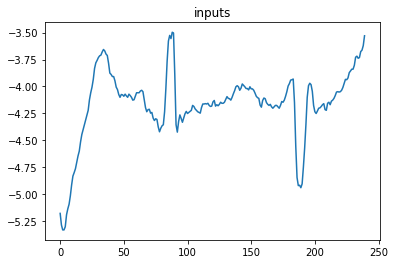

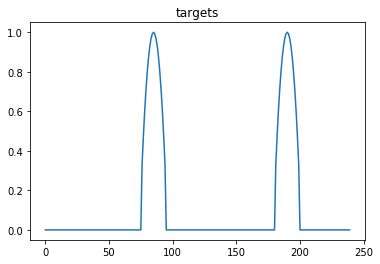

In [12]:
# let's visualize the model's input data and target data
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
    
plt.plot(inp[0,:])
plt.title('inputs')
plt.show()
plt.plot(targ[0,:])
plt.title('targets')
plt.show()

In [13]:
from tensorflow.python.keras import layers

ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(64, activation='relu', input_shape=(seqL*ninputs,)))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Dense(seqL * ninputs))
ffwdModel.summary()

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData, epochs=10, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                15424     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 240)               15600     
Total params: 35,184
Trainable params: 35,184
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0973 - mean_absolute_error: 0.1647 - val_loss: 0.0617 - val_mean_absolute_error: 0.1487
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0637 - mean_absolute_error: 0.1509 - val_loss: 0.0612 - val_me

500/500 [==============================] - 1s 2ms/step - loss: 0.0608 - mean_absolute_error: 0.1502
test mean square error (loss):  0.0608103978857398   test absolute error:  0.15022485


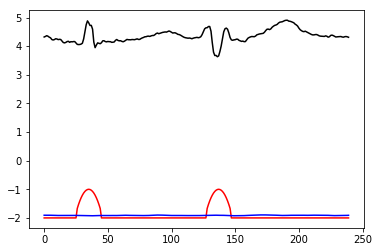

In [20]:
out = ffwdModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
plt.show()

In [22]:
numLstmUnits = 32
denseDim = ninputs
ffwdModelSequential = tf.keras.Sequential()
ffwdModelSequential.add(layers.Reshape((seqL,ninputs), input_shape=(seqL*ninputs,)))
ffwdModelSequential.add(layers.LSTM(units=numLstmUnits, return_sequences=True))         
ffwdModelSequential.add(layers.LSTM(units=numLstmUnits, return_sequences=True))
ffwdModelSequential.add(layers.TimeDistributed(layers.Dense(denseDim)))
ffwdModelSequential.add(layers.Reshape((seqL*ninputs,)))

ffwdModelSequential.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModelSequential.fit(trainData,  epochs=10, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

Epoch 1/10
1000/1000 [==============================] - 83s 83ms/step - loss: 0.0660 - mean_absolute_error: 0.1542 - val_loss: 0.0620 - val_mean_absolute_error: 0.1514
Epoch 2/10
1000/1000 [==============================] - 80s 80ms/step - loss: 0.0456 - mean_absolute_error: 0.1267 - val_loss: 0.0266 - val_mean_absolute_error: 0.0938
Epoch 3/10
1000/1000 [==============================] - 80s 80ms/step - loss: 0.0267 - mean_absolute_error: 0.0925 - val_loss: 0.0169 - val_mean_absolute_error: 0.0710
Epoch 4/10
1000/1000 [==============================] - 80s 80ms/step - loss: 0.0195 - mean_absolute_error: 0.0772 - val_loss: 0.0130 - val_mean_absolute_error: 0.0656
Epoch 5/10
1000/1000 [==============================] - 81s 81ms/step - loss: 0.0161 - mean_absolute_error: 0.0678 - val_loss: 0.0108 - val_mean_absolute_error: 0.0531
Epoch 6/10
1000/1000 [==============================] - 82s 82ms/step - loss: 0.0138 - mean_absolute_error: 0.0606 - val_loss: 0.0100 - val_mean_absolute_error:

500/500 [==============================] - 18s 35ms/step - loss: 0.0091 - mean_absolute_error: 0.0454
test mean square error (loss):  0.009085805913899094   test absolute error:  0.045415346


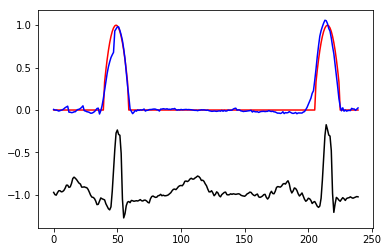

In [26]:
ffwdModelSequential.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
out = ffwdModelSequential.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModelSequential.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0],'r',t,output[0],'b')
plt.show()

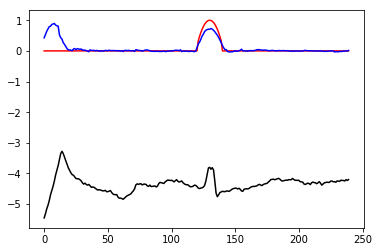

In [25]:
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0],'r',t,output[0],'b')
plt.show()